# House Price Prediction Using Machine Learning

**Goal:** Predict house prices using property characteristics and identify the most influential factors affecting residential property values.  
**Dataset:** Ames Housing Dataset  

**Kaggle URL:** https://www.kaggle.com/datasets/shashanknecrothapa/ames-housing-dataset?utm_source=chatgpt.com&select=AmesHousing.csv

**Task type:** Supervised regression  
**Focus:** Model comparison, feature engineering, evaluation, and interpretability


## Introduction

Accurate house price prediction is important for buyers, sellers, real estate professionals, and urban planners. Property values depend on a combination of structural features, location-related attributes, and overall housing quality. Machine learning models can capture complex relationships between these factors and property prices.

In this project, the objective is to build regression models that predict house prices using the Ames Housing dataset. Beyond prediction accuracy, the project emphasizes proper preprocessing, evaluation using appropriate regression metrics, and interpretability to understand the key drivers of housing prices.


## Problem Statement

Given a set of housing attributes such as size, quality, age, and neighborhood characteristics, the goal is to predict the sale price of a house.

This is a supervised regression problem where the target variable is **SalePrice**. Model performance is evaluated using metrics such as RMSE and R² to assess prediction accuracy and explanatory power.


## Project Workflow

The project follows these steps:

1. Load and inspect the housing dataset  
2. Perform data quality checks and exploratory analysis  
3. Clean and preprocess data (missing values, encoding, scaling)  
4. Engineer meaningful features  
5. Train and compare regression models  
6. Evaluate models using RMSE and R²  
7. Interpret feature importance  
8. Summarize insights and housing-related implications


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

from sklearn.metrics import mean_squared_error, r2_score

RANDOM_STATE = 42


In [ ]:
DATA_PATH = "/content/drive/MyDrive/Colab Notebooks/data/AmesHousing.csv"
df = pd.read_csv(DATA_PATH)

print("Shape:", df.shape)
df.head()


Shape: (2930, 82)


,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,...,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000
3,4,526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,244000
4,5,527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,...,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,189900


## Data Quality Checks

Here I'll inspect:

* Missing values
* Target summary
* Price distribution

This helps identify preprocessing needs and sets expectations for evaluation metrics.


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2930 entries, 0 to 2929
Data columns (total 82 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Order            2930 non-null   int64  
 1   PID              2930 non-null   int64  
 2   MS SubClass      2930 non-null   int64  
 3   MS Zoning        2930 non-null   object 
 4   Lot Frontage     2440 non-null   float64
 5   Lot Area         2930 non-null   int64  
 6   Street           2930 non-null   object 
 7   Alley            198 non-null    object 
 8   Lot Shape        2930 non-null   object 
 9   Land Contour     2930 non-null   object 
 10  Utilities        2930 non-null   object 
 11  Lot Config       2930 non-null   object 
 12  Land Slope       2930 non-null   object 
 13  Neighborhood     2930 non-null   object 
 14  Condition 1      2930 non-null   object 
 15  Condition 2      2930 non-null   object 
 16  Bldg Type        2930 non-null   object 
 17  House Style   

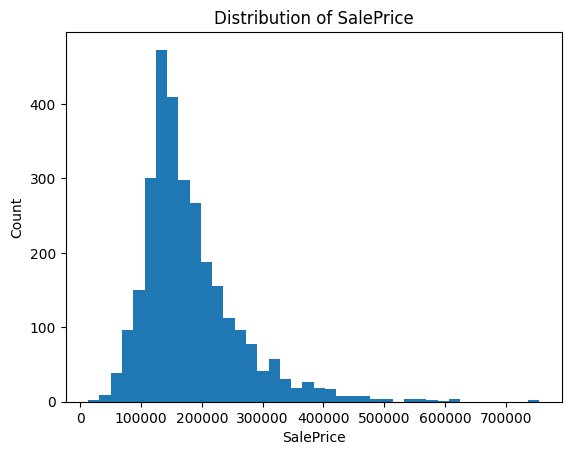

In [ ]:
print(df.info())

missing = df.isna().sum().sort_values(ascending=False)
print("Top missing columns:\n", missing.head(15))

# Target column check
target_col = "SalePrice"
print("\nTarget summary:")
print(df[target_col].describe())

# Price distribution
plt.figure()
plt.hist(df[target_col], bins=40)
plt.title("Distribution of SalePrice")
plt.xlabel("SalePrice")
plt.ylabel("Count")
plt.show()


## Train/Test Split

To improve evaluation reliability I'll split the dataset into training and testing subsets using stratification

In [ ]:
X = df.drop(columns=[target_col])
y = df[target_col]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.20,
    random_state=RANDOM_STATE
)

print("Train:", X_train.shape, "Test:", X_test.shape)


Train: (2344, 81) Test: (586, 81)


## Preprocessing Pipeline

I'll use a robust preprocessing pipeline to find:

* Numeric features: imputation + scaling
* Categorical features: imputation + one-hot encoding

Using `ColumnTransformer` and `Pipeline` ensures the full workflow is reproducible and prevents data leakage.


In [ ]:
numeric_features = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_features = X.select_dtypes(include=["object", "category", "bool"]).columns.tolist()

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)



In [ ]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def evaluate_regression(name, pipeline):
    pipeline.fit(X_train, y_train)
    preds = pipeline.predict(X_test)

    test_rmse = rmse(y_test, preds)
    test_r2 = r2_score(y_test, preds)

    print(f"\n===== {name} =====")
    print(f"Test RMSE: {test_rmse:,.2f}")
    print(f"Test R^2 : {test_r2:.3f}")

    return {
        "Model": name,
        "RMSE": test_rmse,
        "R2": test_r2,
        "Pipeline": pipeline,
        "Preds": preds
    }

def plot_pred_vs_actual(y_true, y_pred, title="Predicted vs Actual"):
    plt.figure()
    plt.scatter(y_true, y_pred, alpha=0.4)
    plt.title(title)
    plt.xlabel("Actual SalePrice")
    plt.ylabel("Predicted SalePrice")
    plt.show()


## Model Training and Comparison

Now, I will compare classical regression and tree-based models:
- Linear Regression (baseline)
- Ridge Regression
- Lasso Regression
- Random Forest Regressor
- Gradient Boosting Regressor

I'll evaluate using:
- RMSE (lower is better)
- R² (higher is better)


In [ ]:
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(alpha=10.0, random_state=RANDOM_STATE),
    "Lasso Regression": Lasso(alpha=0.001, random_state=RANDOM_STATE, max_iter=5000),
    "Random Forest": RandomForestRegressor(
        n_estimators=400,
        random_state=RANDOM_STATE,
        n_jobs=-1
    ),
    "Gradient Boosting": GradientBoostingRegressor(random_state=RANDOM_STATE)
}

results = []

for name, model in models.items():
    pipe = Pipeline(steps=[
        ("preprocess", preprocess),
        ("model", model)
    ])
    res = evaluate_regression(name, pipe)
    results.append(res)

results_df = pd.DataFrame([{k: v for k, v in r.items() if k in ["Model", "RMSE", "R2"]} for r in results])
results_df.sort_values("RMSE").reset_index(drop=True)



===== Linear Regression =====
Test RMSE: 29,635.36
Test R^2 : 0.890

===== Ridge Regression =====
Test RMSE: 29,160.83
Test R^2 : 0.894


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:656: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 421630088982.9701, tolerance: 1393681263.8331819
  model = cd_fast.sparse_enet_coordinate_descent(



===== Lasso Regression =====
Test RMSE: 29,257.88
Test R^2 : 0.893

===== Random Forest =====
Test RMSE: 26,731.76
Test R^2 : 0.911

===== Gradient Boosting =====
Test RMSE: 26,730.80
Test R^2 : 0.911


,Model,RMSE,R2
0,Gradient Boosting,26730.799579,0.910879
1,Random Forest,26731.763811,0.910872
2,Ridge Regression,29160.830790,0.893938
3,Lasso Regression,29257.884250,0.893231
4,Linear Regression,29635.358986,0.890458


Best model by RMSE: Gradient Boosting


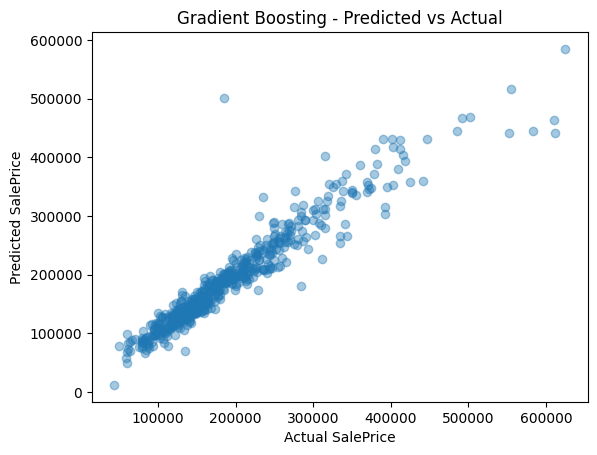

In [ ]:
# Model comparison

best_row = min(results, key=lambda x: x["RMSE"])
best_name = best_row["Model"]
best_pipe = best_row["Pipeline"]
best_preds = best_row["Preds"]

print("Best model by RMSE:", best_name)
plot_pred_vs_actual(y_test, best_preds, title=f"{best_name} - Predicted vs Actual")


# Interpretability: Feature Importance

This will work for Random Forest and Gradient Boosting. If Ridge/Lasso wins, we use coefficients.

Top 15 Features Driving SalePrice Predictions:


,feature,importance
0,Overall Qual,0.516704
1,Gr Liv Area,0.119165
2,Garage Cars,0.057605
3,Total Bsmt SF,0.052106
4,1st Flr SF,0.032025
5,2nd Flr SF,0.028978
6,BsmtFin SF 1,0.027851
7,Year Built,0.019538
8,Lot Area,0.015838
9,Full Bath,0.014969


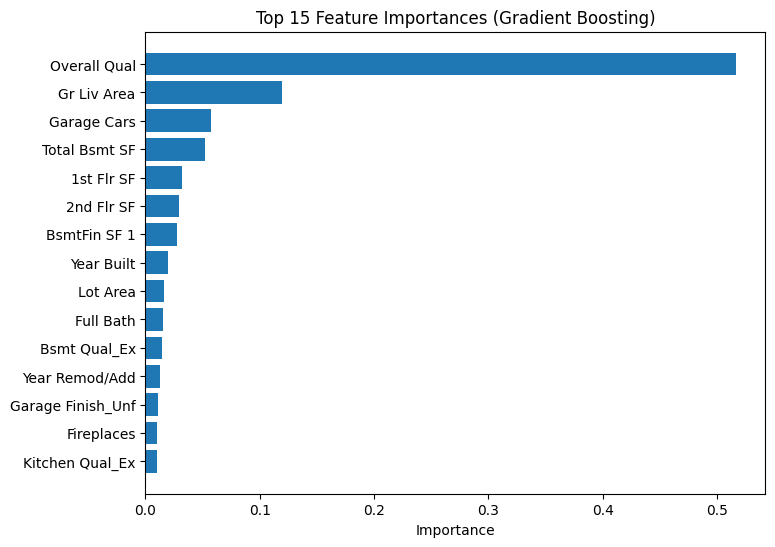

In [ ]:
pre = best_pipe.named_steps["preprocess"]
model = best_pipe.named_steps["model"]

# Feature names after one-hot encoding
ohe = pre.named_transformers_["cat"].named_steps["onehot"]
cat_feature_names = ohe.get_feature_names_out(categorical_features)
feature_names = np.concatenate([numeric_features, cat_feature_names])

if hasattr(model, "feature_importances_"):
    importances = model.feature_importances_

    fi = (
        pd.DataFrame({"feature": feature_names, "importance": importances})
        .sort_values("importance", ascending=False)
        .reset_index(drop=True)
    )

    print("Top 15 Features Driving SalePrice Predictions:")
    display(fi.head(15))

    plt.figure(figsize=(8, 6))
    plt.barh(fi.head(15)["feature"][::-1], fi.head(15)["importance"][::-1])
    plt.xlabel("Importance")
    plt.title(f"Top 15 Feature Importances ({best_name})")
    plt.show()

elif hasattr(model, "coef_"):
    coefs = model.coef_
    coef_df = (
        pd.DataFrame({"feature": feature_names, "coefficient": coefs})
        .sort_values("coefficient", ascending=False)
        .reset_index(drop=True)
    )

    print("Top Features Increasing SalePrice:")
    display(coef_df.head(15))

    print("Top Features Decreasing SalePrice:")
    display(coef_df.tail(15))


# Model Comparison

| Model                 | RMSE          | R²        |
| --------------------- | ------------- | --------- |
| **Gradient Boosting** | **26,730.80** | **0.911** |
| Random Forest         | 26,731.76     | 0.911     |
| Ridge Regression      | 29,160.83     | 0.894     |
| Lasso Regression      | 29,257.88     | 0.893     |
| Linear Regression     | 29,635.36     | 0.890     |

**Best Model:** Gradient Boosting Regressor

The Gradient Boosting model achieved the lowest RMSE and the highest R², indicating strong predictive performance and good generalization to unseen data.

# Model Fit Visualization

The predicted vs actual price plot shows a strong linear alignment along the diagonal, indicating that the model captures price trends well across low-, mid-, and high-priced homes. Some dispersion at higher prices is expected due to market variability and fewer high-value samples.

# Key Insights

- Overall property quality is by far the strongest driver of house prices, contributing more than half of total model importance.

- Living area size plays a major role, with above-ground space being one of the most influential predictors.

- Garage capacity and basement size significantly affect property value, highlighting the importance of usable space.

- Property age and renovations influence prices, with newer and recently remodeled houses commanding higher values.

- Lot size and number of bathrooms contribute meaningfully, reflecting buyer preferences for space and functionality.

- High-quality kitchens, basements, and fireplaces provide additional value premiums.

# Practical Implications

- Buyers can focus on overall quality and living area when evaluating price fairness.

- Sellers can prioritize renovations that improve high-impact features such as quality ratings and usable living space.

- Real estate professionals can use model insights to explain pricing differences between similar properties.

- Urban analysts can leverage the model to study how structural characteristics influence housing market dynamics.

# Conclusion

This project demonstrates a complete machine learning regression pipeline for housing price prediction using the Ames Housing dataset. The Gradient Boosting model achieved strong performance with an RMSE of approximately 26,731 and an R² of 0.91, indicating high predictive accuracy. Feature importance analysis revealed that overall quality, living area, garage capacity, and basement size are the dominant drivers of residential property values.